# Install packages

In [75]:
# Install required packages
import numpy as np
import scipy.spatial as sp
from IPython.display import Markdown
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

# Import pyomo environment and setup gurobi solver
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition
import gurobipy 
solver = pyo.SolverFactory("gurobi_direct")

# Main functions

0. Instance to explain + model + features
    Fully needed
1. Determine sampling method + sample
    Needed:
    - Sample method
    - Feasibility/ bounded check
2. Evaluate samples
    Needed:
    - Optimization model
3. Determine closeness samples
    Needed:
    -Distance metric/kernel function
4. Fit explanation models:
    Needed:
    - Train and test split
    - Dictionary of candidate functions with hyperparameters
    - Performance metric
5. Plot feature importance


In [28]:
'''
Sample pertubations of instance
Args:     orig          - array of original instance
          index_list    - list with indices of originial array to perturb
          method        - method to perturb instance. Only option now: normal
          var           - variance for pertubation
          size          - number of perturbed instances
Output:   org_plus_smpl - array with rows original instance and size perturbed instances
'''

np.random.seed(42)

def sample_perturbations_normal(orig, ftr_index_list, model_lcl, mean = 0, var = 0.2, size = 1000, feasibility_check = True, bounded_check = True):
    
    org_plus_prtb = [orig]
    cntr = 1
    incr = 1

    while cntr < size:
        orig_with_noise = copy.deepcopy(orig)
        good_sample = True
        
        for j in range(len(orig)):
            if j in ftr_index_list:
                lcl_var = orig_with_noise[j] * var
                orig_with_noise[j] = orig_with_noise[j] + np.random.normal(mean, lcl_var)

        if feasibility_check:
            good_sample = good_sample * model_lcl(orig_with_noise, 'feasibility')
        if bounded_check:
            good_sample = good_sample * model_lcl(orig_with_noise, 'bounded')

        if good_sample == True:
            org_plus_prtb.append(np.asarray(orig_with_noise))
            cntr  = cntr + 1
        
        incr = incr + 1

        if incr > size and cntr < size/2:
            raise ValueError("Too many unbounded or unfeasible samples, change sampling method")
        
    org_plus_prtb = np.asarray(org_plus_prtb)

    return org_plus_prtb


def sample_perturbations_epsilon(orig, ftr_index_list, model_lcl, epsilon = 1, size = 1000, feasibility_check = True, bounded_check = True):
    
    org_plus_prtb = [orig]
    prtb = np.zeros(len(size),len(ftr_index_list))
    cntr = 1
    incr = 1

    while cntr < size:
        orig_with_noise = copy.deepcopy(orig)
        
        for j in range(len(orig)):
            if j in ftr_index_list:
                lmb = np.random.uniform(-1, 1)
                orig_with_noise[j] = orig_with_noise[j] + lmb * epsilon
                prtb[cntr][j] = lmb

        if feasibility_check:
            good_sample = good_sample * model_lcl(orig_with_noise, 'feasibility')
        if bounded_check:
            good_sample = good_sample * model_lcl(orig_with_noise, 'bounded')

        if good_sample == True:
            org_plus_prtb.append(np.asarray(orig_with_noise))
            cntr  = cntr + 1
        
        incr = incr + 1

        if incr > size and cntr < size/2:
            raise ValueError("Too many unbounded or unfeasible samples, change sampling method")
        
    org_plus_prtb = np.asarray(org_plus_prtb)
    prtb = np.asarray(prtb)

    return org_plus_prtb, prtb

def sample_perturbations_scalar(orig, ftr_index_list, model_lcl,  lower_bound = 0.2, upper_bound = 2, size = 1000, feasibility_check = True, bounded_check = True):

    org_plus_prtb = [orig]
    prtb = np.ones(len(size),len(ftr_index_list))
    cntr = 1
    incr = 1

    while cntr < size:
        orig_with_noise = copy.deepcopy(orig)
        
        for j in range(len(orig)):
            if j in ftr_index_list:
                lmb = np.random.uniform(lower_bound, upper_bound)
                orig_with_noise[j] = orig_with_noise[j] * lmb 
                prtb[cntr][j] = lmb

        if feasibility_check:
            good_sample = good_sample * model_lcl(orig_with_noise, 'feasibility')
        if bounded_check:
            good_sample = good_sample * model_lcl(orig_with_noise, 'bounded')

        if good_sample == True:
            org_plus_prtb.append(np.asarray(orig_with_noise))
            cntr  = cntr + 1
        
        incr = incr + 1

        if incr > size and cntr < size/2:
            raise ValueError("Too many unbounded or unfeasible samples, change sampling method")
        
    org_plus_prtb = np.asarray(org_plus_prtb)
    prtb = np.asarray(prtb)
    
    return org_plus_prtb, prtb

In [29]:
# Compute distance between two vectors and evaluate the kernel function
# kernel_width: kernel width for the exponential kernel.
#                 If None, defaults to sqrt (number of columns) * 0.75
    
def std_weight_function(a, b, kernel_width = None):
    d = np.linalg.norm(a - b)
    if kernel_width is None:
        krnl_wdth = 0.75 * len(a)
    else:
        krnl_wdth = kernel_width
    return np.exp(-(d ** 2) / (2* krnl_wdth ** 2))
    
def get_weights_from_samples(smpls, function = None, width = None):
    
    org = smpls[0]
    weights = []

    for smpl in smpls:
        if function is not None:
            weights.append(function(org, smpl))
        else:
            weights.append(std_weight_function(org, smpl, width))

    return weights

In [30]:
def get_values_from_samples(smpls, model_lcl):
    values = []
    
    for smpl in smpls:
        values.append(model_lcl(smpl))
    
    return values

In [70]:
def model_search(model_type, hyper_prm_dct, X_train, X_test, Y_train, Y_test, W_train, W_test):
    
    best_perf = np.inf
    best_srgt = np.nan
    best_prms = np.nan

    hyper_prm_grid = ParameterGrid(hyper_prm_dct)
    for hyper_prm_set in hyper_prm_grid:

        if model_type == 'DecisionTreeRegressor':
            surrogate = DecisionTreeRegressor(random_state=42, **hyper_prm_set)
        elif model_type == 'DecisionTreeClassifier':
            surrogate = DecisionTreeClassifier(random_state=42, **hyper_prm_set)
        elif model_type == 'LinearRegression':
            surrogate = LinearRegression(**hyper_prm_set)
        elif model_type == 'RidgeRegression':
            surrogate = Ridge(random_state=42, **hyper_prm_set)
        elif model_type == 'LASSORegression':
            surrogate = Lasso(random_state=42, **hyper_prm_set)
        elif model_type == 'SVM':
            surrogate = svm(random_state=42, **hyper_prm_set)
        elif model_type == 'LogisticRegression':
            surrogate = LogisticRegression(random_state=42, **hyper_prm_set)
        else:
            raise ValueError("Model type not yet supported, please choose from: DecisionTreeRegressor, DecisionClassifier, LinearRegression, RidgeRegression, LASSORegression, SVM, LogisticRegression")

        surrogate.fit(X_train, Y_train, sample_weight= W_train)
        Y_pred_test = surrogate.predict(X_test)
        train_err = mean_squared_error(Y_test, Y_pred_test, sample_weight= W_test)
        if train_err < best_perf:
            best_perf = train_err
            best_srgt = surrogate
            best_prms = hyper_prm_set
    
    Y_pred_test = best_srgt.predict(X_test)

    rtrn_dict = {}
    rtrn_dict['Model'] = best_srgt
    rtrn_dict['Best hyperparameters'] = best_prms
    if model_type in ['DecisionTreeRegressor', 'DecisionTreeClassifier']:
        rtrn_dict['Best model feature importance'] = best_srgt.feature_importances_
    else:
        rtrn_dict['Best model coefficients'] = best_srgt.coef_
        rtrn_dict['Best model feature importance'] = best_srgt.coef_ * X_train.std(axis=0)
    rtrn_dict['Wmse'] = mean_squared_error(Y_test, Y_pred_test, sample_weight= W_test)
    rtrn_dict['mse']  = mean_squared_error(Y_test, Y_pred_test)
    rtrn_dict['WL1e'] = mean_absolute_error(Y_test, Y_pred_test, sample_weight= W_test)
    rtrn_dict['L1e']  = mean_absolute_error(Y_test, Y_pred_test)
    rtrn_dict['Y_pred_test']  = Y_pred_test
    rtrn_dict['Y_test']  = Y_test

    return rtrn_dict

In [32]:
def train_test_explanation_models(pos_mdls, X, Y, W, feature_indices, train_part = 0.8):

    X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X[:,feature_indices], Y, W,
                                                                            train_size = train_part, 
                                                                            test_size = 1-train_part, 
                                                                            random_state = 100)
    
    outcome_dict = {}
    for model_type in pos_mdls.keys():

        hyper_prm_dict = pos_mdls[model_type]
        outcome_dict[model_type] = model_search(model_type, hyper_prm_dict, X_train, X_test, Y_train, Y_test, W_train, W_test)
        # if model_type == 'LinearRegression':
        #     print(model_type, outcome_dict[model_type]['Best model parameters'])
            
    return outcome_dict

In [71]:
def plot_explanation_tree(solution_dict, features_lbls, surrogate_type = None):
    if surrogate_type not in ['DecisionTreeRegressor', 'DecisionClassifier']:
        raise ValueError("surrogate_type should be: 'DecisionTreeRegressor' or 'DecisionClassifier'")
    else:
        plt.figure()
        plot_tree(solution_dict[surrogate_type]['Model'], filled=True, feature_names = features_lbls)
        plt.show()


def plot_explanation_feature_importance(solution_dict, features_lbls, surrogate_types = None):
    ind = np.arange(len(features_lbls))
    width = 1/len(surrogate_types)

    fig = plt.figure()
    fig, ax = plt.subplots()
    for i in range(len(surrogate_types)):
        ftr_prm = solution_dict[surrogate_types[i]]['Best model feature importance']
        ftr_imp = np.abs(ftr_prm)/np.sum(np.abs(ftr_prm))
        ax.barh(ind +i* width, ftr_imp, width, label=surrogate_types[i])

    ax.set(yticks=ind + 0.5, yticklabels=features_lbls, ylim=[2*width - 1, len(features_lbls)])
    if len(surrogate_types) > 1:
        ax.legend()
        plt.title('Relative feature importance for different surrogate types.')
    else:
        plt.title('Relative feature importance for ' + surrogate_types[0] + '  surrogate')
    plt.show()

# Apply functions

## Test case

In [58]:
# Set instance and features

# Knapsack with logical features
KS_vals = [9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 6]
KS_wgts = [0.9, 0.02, 0.03, 0.01, 0.04, 0.005, 0.001, 0.015, 0.09, 0.0001]
KS_bdgt = 1
# Concatenate variables
inst_1 = np.concatenate((KS_vals, KS_wgts, [KS_bdgt]))

all_prmt_dict = {}
features_lbls = []

for i in range(len(KS_vals)):
    all_prmt_dict['Value item ' + str(i+1)]  = KS_vals[i]
    # features_lbls.append('Value item ' + str(i+1))
for i in range(len(KS_wgts)):
    all_prmt_dict['Weight item ' + str(i+1)] = KS_wgts[i]
    features_lbls.append('Weight item ' + str(i+1))
all_prmt_dict['Maximum weight allowed'] = KS_bdgt

all_prmt_lbls = list(all_prmt_dict.keys())
all_prmt_vals = list(all_prmt_dict.values())

features_inds = [all_prmt_lbls.index(key) for key in features_lbls]
features_dict = {key: all_prmt_dict[key] for key in features_lbls}
features_vals = features_dict.values()

# samples_sizes = [100, 500, 1000, 2000]

weight_widths = [0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10, 20]

pos_mdls_dict = {'DecisionTreeRegressor':  {'max_depth': [3, 4, 5],
                                            'min_samples_leaf': [10, 50, 100]},
                'LinearRegression':        {},
                'RidgeRegression':         {'alpha': [0.1, 0.5, 1, 2, 5, 10, 50]},
                'LASSORegression':         {'alpha': [0.1, 0.5, 1, 2, 5, 10, 50]}
                }

In [45]:
# Binary LP knapsack
def model_KS_bin(vals, output = 'goal', solver = solver):

    # Define a model
    model = pyo.ConcreteModel('Knapsack 0-1 model')

    # Declare decision variables
    model.x = pyo.Var(range(int(((len(vals)-1)/2))), domain=pyo.Binary)

    # Declare objective
    model.objective = pyo.Objective(expr = sum(vals[i]*model.x[i] for i in range(int(((len(vals)-1)/2)))),
                                sense = pyo.maximize)

    # Declare constraints
    model.budget = pyo.Constraint(expr = sum(vals[i+int(((len(vals)-1)/2))]*model.x[i] for i in range(int(((len(vals)-1)/2)))) <= vals[-1])

    # Solve
    result = solver.solve(model)

    if output == 'goal':
        return model.objective()

    elif output == 'bounded' or output == 'feasibility':
        return result.solver.termination_condition != TerminationCondition.infeasibleOrUnbounded
    
    else:
        raise ValueError("Output not supported for model function")

In [53]:
# Get samples, weights, and values
samples = sample_perturbations_normal(all_prmt_vals, features_inds, model_lcl = model_KS_bin)
weights = []
for wdth in weight_widths:
    weights.append(get_weights_from_samples(samples, width=wdth))
yvalues = get_values_from_samples(samples, model_KS_bin)

In [74]:
# for i in range(len(weight_widths)):
#     outcome_dict = train_test_explanation_models(pos_mdls_dict, samples, yvalues, weights[i], features_inds)
#     plot_explanation_feature_importance(outcome_dict, features_lbls, surrogate_types=list(outcome_dict.keys()))

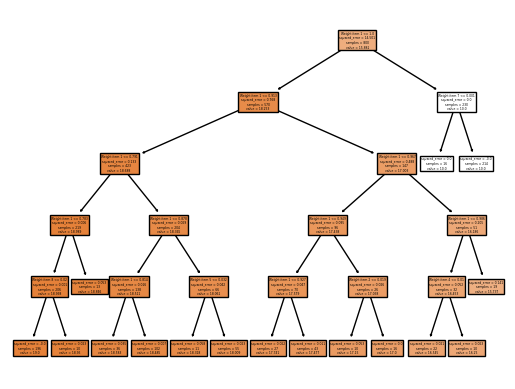

In [57]:
plot_explanation_tree(outcome_dict, features_lbls, surrogate_type='DecisionTreeRegressor')

## Experiment: Knapsack

### Constraint parameters

In [110]:
# Set instance and features

all_instances = {}

for i in range(10):
    all_instances['Instance '+str(i+1)] = {}
    all_instances['Instance '+str(i+1)]['Values']   = np.random.normal(1, 0.3, size = 50)
    all_instances['Instance '+str(i+1)]['Weights']  = np.random.normal(0.04, 0.005, size = 50)
    all_instances['Instance '+str(i+1)]['Budget']   = [1.0]
    all_instances['Instance '+str(i+1)]['Features'] = [*range(50, 100)] 

    all_instances['Instance '+str(i+11)] = {}
    all_instances['Instance '+str(i+11)]['Values']  = np.random.uniform(0.1, 4, size = 50)
    all_instances['Instance '+str(i+11)]['Weights'] = np.random.uniform(0.01, 0.06, size = 50)
    all_instances['Instance '+str(i+11)]['Budget']  = [1.0]
    all_instances['Instance '+str(i+11)]['Features'] = [*range(50, 100)] 

for i in range(5):
    all_instances['Instance '+str(i+21)] = {}
    all_instances['Instance '+str(i+21)]['Values']  = np.random.normal(1, 0.3, size = 100)
    all_instances['Instance '+str(i+21)]['Weights'] = np.random.normal(0.04, 0.005, size = 100)
    all_instances['Instance '+str(i+21)]['Budget']  = [1.0]
    all_instances['Instance '+str(i+21)]['Features'] = [*range(100, 200)] 

    all_instances['Instance '+str(i+26)] = {}
    all_instances['Instance '+str(i+26)]['Values']  = np.random.uniform(0.1, 4, size = 100)
    all_instances['Instance '+str(i+26)]['Weights'] = np.random.uniform(0.01, 0.06, size = 100)
    all_instances['Instance '+str(i+26)]['Budget']  = [1.0]
    all_instances['Instance '+str(i+26)]['Features'] = [*range(100, 200)] 

# samples_sizes = [10, 25, 50, 100, 500, 1000, 2000]

weight_widths = [0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10]

pos_mdls_dict = {'DecisionTreeRegressor':  {'max_depth': [3, 4, 5],
                                            'min_samples_leaf': [10, 50, 100]},
                'LinearRegression':        {},
                'RidgeRegression':         {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
                'LASSORegression':         {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
                }

In [113]:
for key in all_instances.keys():
    all_instances[key]['Explainers'] = {}
    all_val = np.concatenate((all_instances[key]['Values'],all_instances[key]['Weights'],all_instances[key]['Budget']))
    
    samples = sample_perturbations_normal(all_val, all_instances[key]['Features'], model_lcl = model_KS_bin)
    yvalues = get_values_from_samples(samples, model_KS_bin)

    for wdth in weight_widths:
        weights_lcl = get_weights_from_samples(samples, width=wdth)
        all_instances[key]['Explainers']['Weight width '+ str(wdth)] = train_test_explanation_models(pos_mdls_dict, samples, yvalues, weights_lcl, all_instances[key]['Features'])

In [145]:
df = pd.DataFrame.from_dict({(i,j,k): all_instances[i]['Explainers'][j][k]
                            for i in all_instances.keys() 
                            for j in all_instances[i]['Explainers'].keys()
                            for k in all_instances[i]['Explainers'][j].keys()},
                            orient='index')
df.index.names = ['Instances', 'Weight width', 'Model type']
display(df)

Model  \
Instances   Weight width      Model type                                                                 
Instance 1  Weight width 0.01 DecisionTreeRegressor  DecisionTreeRegressor(max_depth=3, min_samples...   
                              LinearRegression                                      LinearRegression()   
                              RidgeRegression                       Ridge(alpha=0.01, random_state=42)   
                              LASSORegression                       Lasso(alpha=0.01, random_state=42)   
            Weight width 0.1  DecisionTreeRegressor  DecisionTreeRegressor(max_depth=3, min_samples...   
...                                                                                                ...   
Instance 30 Weight width 5    LASSORegression                       Lasso(alpha=0.01, random_state=42)   
            Weight width 10   DecisionTreeRegressor  DecisionTreeRegressor(max_depth=5, min_samples...   
                              LinearRegression                                      LinearRegression()   
                              RidgeRegression                       Ridge(alpha=0.01, random_state=42)   
                              LASSORegression                       Lasso(alpha=0.01, random_state=42)   

                                                                          Best hyperparameters  \
Instances   Weight width      Model type                                                         
Instance 1  Weight width 0.01 DecisionTreeRegressor  {'max_depth': 3, 'min_samples_leaf': 100}   
                              LinearRegression                                              {}   
                              RidgeRegression                                  {'alpha': 0.01}   
                              LASSORegression                                  {'alpha': 0.01}   
            Weight width 0.1  DecisionTreeRegressor   {'max_depth': 3, 'min_samples_leaf': 50}   
...                                                                                        ...   
Instance 30 Weight width 5    LASSORegression                                  {'alpha': 0.01}   
            Weight width 10   DecisionTreeRegressor   {'max_depth': 5, 'min_samples_leaf': 50}   
                              LinearRegression                                              {}   
                              RidgeRegression                                  {'alpha': 0.01}   
                              LASSORegression                                  {'alpha': 0.01}   

                                                                         Best model feature importance  \
Instances   Weight width      Model type                                                                 
Instance 1  Weight width 0.01 DecisionTreeRegressor  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                              LinearRegression       [0.1074409809420023, -0.07559089413042687, 0.0...   
                              RidgeRegression        [-1.011430407168776e-06, -1.3000390096893283e-...   
                              LASSORegression        [-0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0,...   
            Weight width 0.1  DecisionTreeRegressor  [0.0, 0.0, 0.0, 0.09782152152942543, 0.0, 0.0,...   
...                                                                                                ...   
Instance 30 Weight width 5    LASSORegression        [0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, ...   
            Weight width 10   DecisionTreeRegressor  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                              LinearRegression       [0.00723889599526492, -0.0610390699472028, -0....   
                              RidgeRegression        [0.043685020922850426, -0.057448999878812704, ...   
                              LASSORegression        [0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, ...   

                                                         Wmse   

In [147]:
df_ovrvw = df.groupby(level = ['Weight width', 'Model type']).agg({'Wmse': ['mean', 'std'], 'mse': ['mean', 'std'], 'WL1e': ['mean', 'std'], 'L1e': ['mean', 'std']})

In [148]:
display(df_ovrvw)

Wmse                 mse  \
                                             mean       std      mean   
Weight width      Model type                                            
Weight width 0.01 DecisionTreeRegressor  1.110617  0.806133  3.045399   
                  LASSORegression        2.827344  2.836988  5.450131   
                  LinearRegression       4.133897  6.473742  8.119514   
                  RidgeRegression        2.827267  2.837018  5.449977   
Weight width 0.1  DecisionTreeRegressor  2.032957  1.550793  2.046578   
                  LASSORegression        2.215951  1.619989  2.231162   
                  LinearRegression       0.216684  0.217624  0.219424   
                  RidgeRegression        0.391057  0.421640  0.394304   
Weight width 0.5  DecisionTreeRegressor  2.054675  1.560786  2.055216   
                  LASSORegression        2.229430  1.632650  2.230035   
                  LinearRegression       0.219513  0.220923  0.219619   
                  RidgeRegression        0.354029  0.373044  0.354147   
Weight width 1    DecisionTreeRegressor  2.054094  1.559104  2.054228   
                  LASSORegression        2.229853  1.633049  2.230005   
                  LinearRegression       0.219605  0.221031  0.219631   
                  RidgeRegression        0.353002  0.371687  0.353031   
Weight width 1.5  DecisionTreeRegressor  2.054171  1.559178  2.054230   
                  LASSORegression        2.229932  1.633122  2.229999   
                  LinearRegression       0.219622  0.221051  0.219633   
                  RidgeRegression        0.352813  0.371437  0.352826   
Weight width 10   DecisionTreeRegressor  2.054231  1.559237  2.054232   
                  LASSORegression        2.229993  1.633180  2.229995   
                  LinearRegression       0.219635  0.221067  0.219635   
                  RidgeRegression        0.352665  0.371242  0.352665   
Weight width 2    DecisionTreeRegressor  2.054197  1.559204  2.054231   
                  LASSORegression        2.229959  1.633148  2.229997   
                  LinearRegression       0.219627  0.221058  0.219634   
                  RidgeRegression        0.352746  0.371350  0.352754   
Weight width 5    DecisionTreeRegressor  2.054226  1.559233  2.054232   
                  LASSORegression        2.229989  1.633176  2.229995   
                  LinearRegression       0.219634  0.221066  0.219635   
                  RidgeRegression        0.352675  0.371255  0.352676   

                                                        WL1e            \
                                               std      mean       std   
Weight width      Model type                                             
Weight width 0.01 DecisionTreeRegressor   2.497966  0.771609  0.300581   
                  LASSORegression         4.689211  1.306083  0.694051   
                  LinearRegression       11.011190  1.286061  1.167354   
                  RidgeRegression         4.689297  1.306058  0.694060   
Weight width 0.1  DecisionTreeRegressor   1.563981  1.066676  0.406016   
                  LASSORegression         1.634055  1.119352  0.414515   
                  LinearRegression        0.220364  0.333703  0.160450   
                  RidgeRegression         0.426286  0.446849  0.223317   
Weight width 0.5  DecisionTreeRegressor   1.561342  1.071736  0.405280   
                  LASSORegression         1.633213  1.122799  0.416193   
                  LinearRegression        0.221031  0.335815  0.161935   
                  RidgeRegression         0.373209  0.426562  0.208493   
Weight width 1    DecisionTreeRegressor   1.559240  1.071935  0.405517   
                  LASSORegression         1.633189  1.122906  0.416245   
                  LinearRegression        0.221058  0.335882  0.161983   
                  RidgeRegression         0.371729  0.425983  0.208067   
Weight width 1.5  DecisionTreeRegressor   1.559239  1.071954  0.405525   
         

### Cost parameters

In [152]:
# Set instance and features

all_instances_c = {}

for i in range(10):
    all_instances_c['Instance '+str(i+1)] = {}
    all_instances_c['Instance '+str(i+1)]['Values']   = np.random.normal(1, 0.3, size = 50)
    all_instances_c['Instance '+str(i+1)]['Weights']  = np.random.normal(0.04, 0.005, size = 50)
    all_instances_c['Instance '+str(i+1)]['Budget']   = [1.0]
    all_instances_c['Instance '+str(i+1)]['Features'] = [*range(50)] 

    all_instances_c['Instance '+str(i+11)] = {}
    all_instances_c['Instance '+str(i+11)]['Values']  = np.random.uniform(0.1, 4, size = 50)
    all_instances_c['Instance '+str(i+11)]['Weights'] = np.random.uniform(0.01, 0.06, size = 50)
    all_instances_c['Instance '+str(i+11)]['Budget']  = [1.0]
    all_instances_c['Instance '+str(i+11)]['Features'] = [*range(50)] 

for i in range(5):
    all_instances_c['Instance '+str(i+21)] = {}
    all_instances_c['Instance '+str(i+21)]['Values']  = np.random.normal(1, 0.3, size = 100)
    all_instances_c['Instance '+str(i+21)]['Weights'] = np.random.normal(0.04, 0.005, size = 100)
    all_instances_c['Instance '+str(i+21)]['Budget']  = [1.0]
    all_instances_c['Instance '+str(i+21)]['Features'] = [*range(100)] 

    all_instances_c['Instance '+str(i+26)] = {}
    all_instances_c['Instance '+str(i+26)]['Values']  = np.random.uniform(0.1, 4, size = 100)
    all_instances_c['Instance '+str(i+26)]['Weights'] = np.random.uniform(0.01, 0.06, size = 100)
    all_instances_c['Instance '+str(i+26)]['Budget']  = [1.0]
    all_instances_c['Instance '+str(i+26)]['Features'] = [*range(100)] 

# samples_sizes = [10, 25, 50, 100, 500, 1000, 2000]

weight_widths = [0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10]

pos_mdls_dict = {'DecisionTreeRegressor':  {'max_depth': [3, 4, 5],
                                            'min_samples_leaf': [10, 50, 100]},
                'LinearRegression':        {},
                'RidgeRegression':         {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
                'LASSORegression':         {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
                }

In [154]:
for key in all_instances_c.keys():
    all_instances_c[key]['Explainers'] = {}
    all_val_c = np.concatenate((all_instances_c[key]['Values'],all_instances_c[key]['Weights'],all_instances_c[key]['Budget']))
    
    samples_c = sample_perturbations_normal(all_val_c, all_instances_c[key]['Features'], model_lcl = model_KS_bin)
    yvalues_c = get_values_from_samples(samples_c, model_KS_bin)

    for wdth in weight_widths[1:]:
        weights_lcl = get_weights_from_samples(samples_c, width=wdth)
        all_instances_c[key]['Explainers']['Weight width '+ str(wdth)] = train_test_explanation_models(pos_mdls_dict, samples_c, yvalues_c, weights_lcl, all_instances_c[key]['Features'])

In [155]:
df_c = pd.DataFrame.from_dict({(i,j,k): all_instances_c[i]['Explainers'][j][k]
                            for i in all_instances_c.keys() 
                            for j in all_instances_c[i]['Explainers'].keys()
                            for k in all_instances_c[i]['Explainers'][j].keys()},
                            orient='index')
df_c.index.names = ['Instances', 'Weight width', 'Model type']
display(df_c)

Model  \
Instances   Weight width     Model type                                                                 
Instance 1  Weight width 0.1 DecisionTreeRegressor  DecisionTreeRegressor(max_depth=3, min_samples...   
                             LinearRegression                                      LinearRegression()   
                             RidgeRegression                       Ridge(alpha=0.01, random_state=42)   
                             LASSORegression                       Lasso(alpha=0.01, random_state=42)   
            Weight width 0.5 DecisionTreeRegressor  DecisionTreeRegressor(max_depth=3, min_samples...   
...                                                                                               ...   
Instance 30 Weight width 5   LASSORegression                       Lasso(alpha=0.01, random_state=42)   
            Weight width 10  DecisionTreeRegressor  DecisionTreeRegressor(max_depth=5, min_samples...   
                             LinearRegression                                      LinearRegression()   
                             RidgeRegression                          Ridge(alpha=5, random_state=42)   
                             LASSORegression                       Lasso(alpha=0.01, random_state=42)   

                                                                         Best hyperparameters  \
Instances   Weight width     Model type                                                         
Instance 1  Weight width 0.1 DecisionTreeRegressor   {'max_depth': 3, 'min_samples_leaf': 10}   
                             LinearRegression                                              {}   
                             RidgeRegression                                  {'alpha': 0.01}   
                             LASSORegression                                  {'alpha': 0.01}   
            Weight width 0.5 DecisionTreeRegressor  {'max_depth': 3, 'min_samples_leaf': 100}   
...                                                                                       ...   
Instance 30 Weight width 5   LASSORegression                                  {'alpha': 0.01}   
            Weight width 10  DecisionTreeRegressor   {'max_depth': 5, 'min_samples_leaf': 10}   
                             LinearRegression                                              {}   
                             RidgeRegression                                     {'alpha': 5}   
                             LASSORegression                                  {'alpha': 0.01}   

                                                                        Best model feature importance  \
Instances   Weight width     Model type                                                                 
Instance 1  Weight width 0.1 DecisionTreeRegressor  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                             LinearRegression       [0.644529343336942, -0.0821181608419546, 0.553...   
                             RidgeRegression        [4.4639543266508167e-23, 1.6114051085686525e-2...   
                             LASSORegression        [0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0....   
            Weight width 0.5 DecisionTreeRegressor  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                                                               ...   
Instance 30 Weight width 5   LASSORegression        [0.0, -0.0, 0.0, 0.24408146889397625, 0.422063...   
            Weight width 10  DecisionTreeRegressor  [0.0, 0.0, 0.0, 0.0, 0.049471955222270374, 0.0...   
                             LinearRegression       [0.016979082007911924, -0.017877280249000604, ...   
                             RidgeRegression        [0.003982882484890906, -0.009721162790623048, ...   
                             LASSORegression        [0.0, -0.0, 0.0, 0.2465506915765073, 0.4238905...   

                                                         Wmse        mse  \
Instances   Weight width  

In [160]:
df_c_ovrvw = df_c.groupby(level = ['Weight width', 'Model type'])[['Wmse', 'mse', 'WL1e', 'L1e']].quantile([0.25, 0.5,  0.75])
display(df_c_ovrvw)

Wmse        mse      WL1e  \
Weight width     Model type                                                  
Weight width 0.1 DecisionTreeRegressor 0.25  0.603449   2.773726  0.762254   
                                       0.50  2.045716   8.146783  1.272854   
                                       0.75  3.694045  11.789986  1.921929   
                 LASSORegression       0.25  0.603449   2.773726  0.762254   
                                       0.50  2.045716   8.146783  1.272854   
...                                               ...        ...       ...   
Weight width 5   LinearRegression      0.50  0.173007   0.176104  0.325305   
                                       0.75  0.244721   0.249163  0.386989   
                 RidgeRegression       0.25  0.084767   0.085200  0.234815   
                                       0.50  0.171507   0.174606  0.324091   
                                       0.75  0.244722   0.249167  0.386990   

                                                  L1e  
Weight width     Model type                            
Weight width 0.1 DecisionTreeRegressor 0.25  1.366728  
                                       0.50  2.441646  
                                       0.75  2.787888  
                 LASSORegression       0.25  1.366728  
                                       0.50  2.441646  
...                                               ...  
Weight width 5   LinearRegression      0.50  0.328152  
                                       0.75  0.389954  
                 RidgeRegression       0.25  0.235247  
                                       0.50  0.327017  
                                       0.75  0.389945  

[84 rows x 4 columns]

In [169]:
df_tst_c = df_c[(df_c['Weight width'] == 'Weight width '+ str(1)) & (df_c['Model type'] == 'LinearRegression') & (df_c['Wmse'] >=2)]
display(df_tst_c)

,level_0,index,Instances,Weight width,Model type,Model,Best hyperparameters,Best model feature importance,Wmse,mse,WL1e,L1e,Y_pred_test,Y_test,Best model coefficients
597,597,597,Instance 26,Weight width 1,LinearRegression,LinearRegression(),{},"[0.3863383274865326, -0.2316250822219914, -0.0...",4.928995,10.360338,1.820797,2.801258,"[106.41507762925254, 111.85078400935772, 105.9...","[110.02819247863425, 114.34517658941317, 107.9...","[0.5545243597541802, -0.6022494979955377, -0.1..."
653,653,653,Instance 27,Weight width 1,LinearRegression,LinearRegression(),{},"[0.5246646703769402, -0.03532766806344795, 0.1...",10.895959,12.888495,3.036624,3.188939,"[118.64316342166967, 111.95467983597628, 114.6...","[119.93667147373365, 115.70012670252213, 116.9...","[1.457845841290408, -0.13086445206516972, 0.18..."
709,709,709,Instance 28,Weight width 1,LinearRegression,LinearRegression(),{},"[-0.04516051678830497, 0.008254693604927513, -...",3.064722,5.603416,1.464352,2.029315,"[122.07023309308212, 125.57003406471568, 119.0...","[123.31992003227076, 124.3038200916339, 119.24...","[-1.0945449441729358, 0.022407983019332445, -0..."
765,765,765,Instance 29,Weight width 1,LinearRegression,LinearRegression(),{},"[0.0520823540977871, 0.8592375068612124, -0.05...",7.683627,13.787365,2.353409,3.236676,"[106.2874113799482, 106.92376382125235, 112.56...","[112.07608736911888, 111.65481371056629, 114.4...","[0.23653474913970562, 1.2353566883668265, -0.0..."
821,821,821,Instance 30,Weight width 1,LinearRegression,LinearRegression(),{},"[-0.00336166460296976, -0.034374104844526444, ...",8.442661,13.272477,2.655313,3.223166,"[102.92858124275259, 99.98360351029706, 105.45...","[106.1121237186032, 105.1651244381477, 109.657...","[-0.07301057406597063, -0.35297825249540726, 0..."


Width: 0.1
Width: 0.5
Width: 1
Width: 1.5
Width: 2
Width: 5
Width: 10


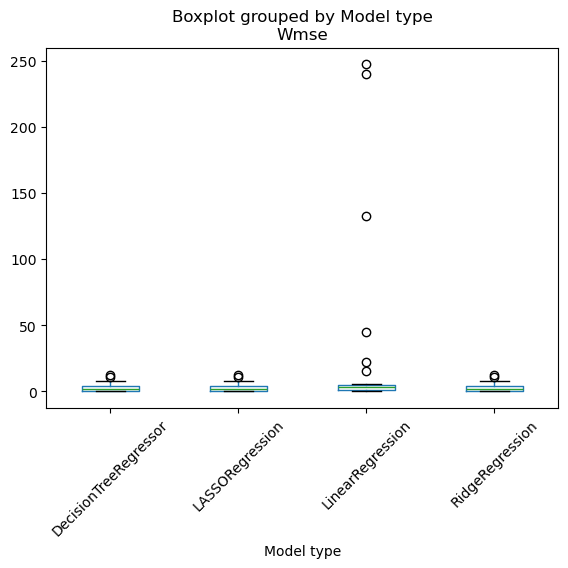

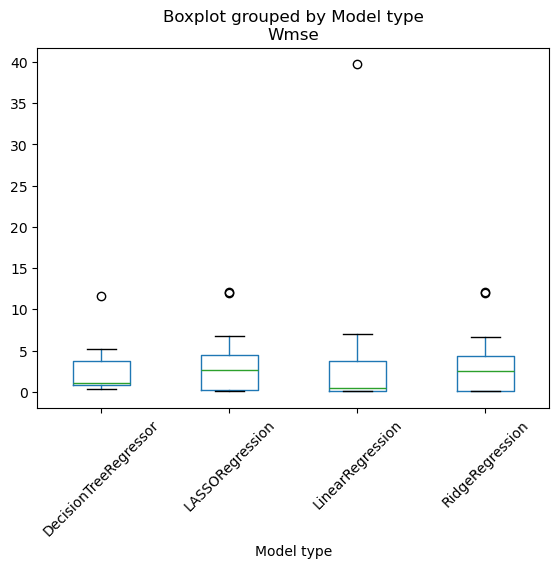

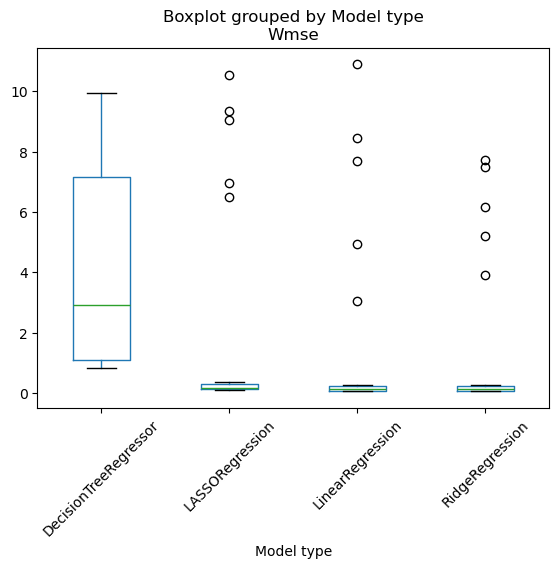

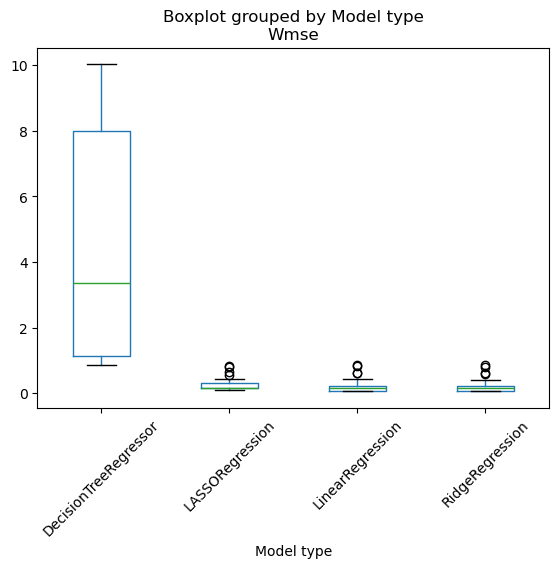

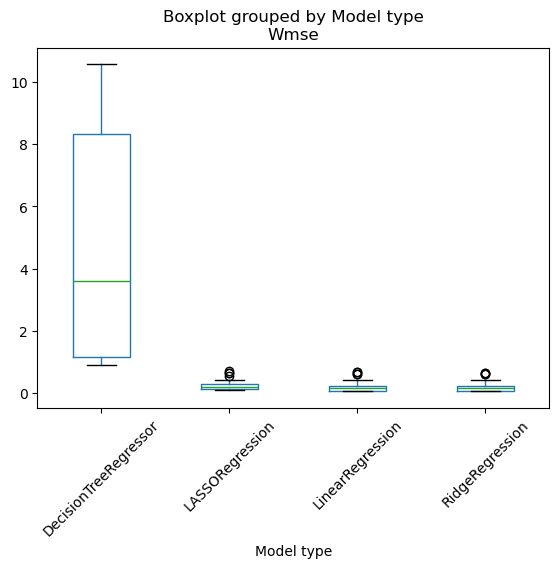

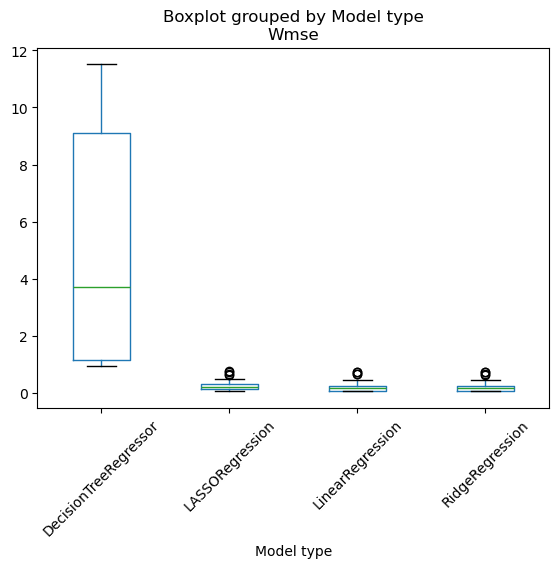

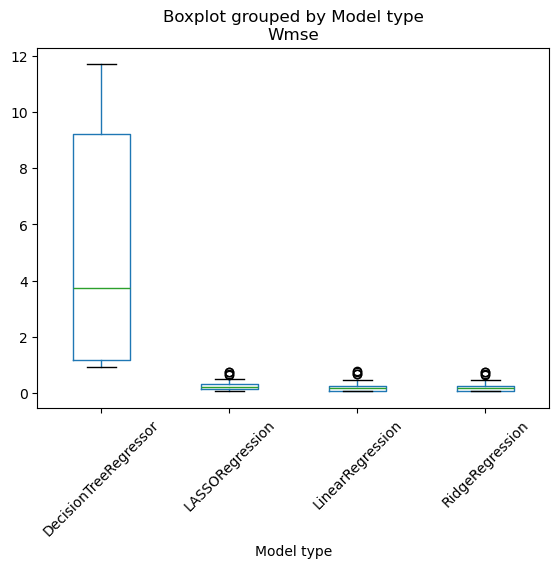

In [167]:
# df_c = df_c.reset_index()
for wdth in weight_widths[1:]:
    df_lcl_c = df_c[df_c['Weight width'] == 'Weight width '+ str(wdth)]
    print("Width:", wdth)
    df_lcl_c.boxplot(by ='Model type', column =['Wmse'], grid = False, rot=45) 